In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
# Load the dataset from Google Drive into a pandas DataFrame
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/PhD_Thesis_Experiments/GitHub_ToChair/FilteredDataSetForExp_001.csv')

In [ ]:
df.shape

(325420, 2)

In [ ]:
df.head()

,consumer_complaint_narrative,hierarchical_label
0,I was using Bread XXXX previously known as XXX...,CheckingSavings::cdCertificateOfDeposit
1,XXXX XXXX XXXX were presented by the XXXX hold...,CheckingSavings::cdCertificateOfDeposit
2,Complaint against NexBank This bank and its em...,CheckingSavings::cdCertificateOfDeposit
3,Chase Bank 9 month lock on a CD at 5 % equals ...,CheckingSavings::cdCertificateOfDeposit
4,"Since XXXX of XX/XX/2024, Synchrony bank has b...",CheckingSavings::cdCertificateOfDeposit


In [ ]:
!pip install nlpaug sentence-transformers imbalanced-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.5/410.5 kB 11.2 MB/s eta 0:00:00


In [ ]:
import nlpaug.augmenter.word as naw
import numpy as np

In [ ]:
import nltk
nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.


True

### Created the balanced dataset.
#### Majority classess undersampled to brig their count to 2000, and the undersampled classess bring their count to 2000.

In [ ]:
# ----------------------------------------------------

TARGET_SAMPLES_PER_CLASS = 2000

# Initialize augmenters
synonym_aug = naw.SynonymAug(aug_src='wordnet')
swap_aug = naw.RandomWordAug(action="swap")
delete_aug = naw.RandomWordAug(action="delete")

# Function to augment text using multiple augmenters
def augment_text(text, num_augments=1): # Reduced num_augments to 1 for efficiency/clarity
    augmented_texts = []
    # Loop to generate 'num_augments' new texts from the original
    for _ in range(num_augments):
        aug_text = text
        # Apply augmenters sequentially
        aug_text = synonym_aug.augment(aug_text)
        # Check if the result is a list and take the first item, otherwise assume it's a string
        if isinstance(aug_text, list):
            aug_text = aug_text[0]

        aug_text = swap_aug.augment(aug_text)
        if isinstance(aug_text, list):
            aug_text = aug_text[0]

        aug_text = delete_aug.augment(aug_text)
        if isinstance(aug_text, list):
            aug_text = aug_text[0]

        # Ensure the final augmented text is a string
        if isinstance(aug_text, str):
            augmented_texts.append(aug_text)

    return augmented_texts

# --- Step 1: Undersample majority classes and collect minority/target classes ---

balanced_df_list = []
minority_groups = {} # To store groups that need augmentation

print(f"Initial class distribution:\n{df['hierarchical_label'].value_counts()}")

for label, group in df.groupby('hierarchical_label'):
    current_count = len(group)

    if current_count > TARGET_SAMPLES_PER_CLASS:
        # Undersampling: Select a random sample of the target size (2000)
        # Use .sample(n=...) for random selection without replacement
        sampled_group = group.sample(n=TARGET_SAMPLES_PER_CLASS, random_state=42)
        balanced_df_list.append(sampled_group)
        print(f"Undersampled '{label}': Reduced from {current_count} to {TARGET_SAMPLES_PER_CLASS}")

    elif current_count == TARGET_SAMPLES_PER_CLASS:
        # Class is already balanced, add it directly
        balanced_df_list.append(group)
        print(f"Kept '{label}': Already at {TARGET_SAMPLES_PER_CLASS}")

    else:
        # Minority class: Store the group for oversampling/augmentation
        minority_groups[label] = group
        print(f"Preparing to augment '{label}': Current count is {current_count}")

# Combine the (already balanced or undersampled) majority classes
final_balanced_df = pd.concat(balanced_df_list, ignore_index=True)

# --- Step 2: Oversample minority classes via Text Augmentation ---

augmented_data = [] # Stores new synthetic records

for label, group in minority_groups.items():
    current_count = len(group)
    texts = group['consumer_complaint_narrative'].tolist()

    # Calculate how many new samples are needed
    needed_samples = TARGET_SAMPLES_PER_CLASS - current_count

    # Calculate the number of times we need to augment each original text, on average
    # We will generate 1 augmented text per original text/iteration
    num_original_texts = len(texts)

    # To get 'needed_samples' total new samples, we iterate through the originals
    # and augment them one by one until we hit the target.

    i = 0
    generated_count = 0

    while generated_count < needed_samples:
        # Select an original text from the pool in a circular manner
        text_to_augment = texts[i % num_original_texts]

        # Generate ONE new text sample (we set num_augments=1 in the function)
        new_texts = augment_text(text_to_augment, num_augments=1)

        if new_texts:
            # Add the new synthetic record
            augmented_data.append((new_texts[0], label))
            generated_count += 1

        i += 1

    print(f"Augmented '{label}': Added {generated_count} new samples to reach {TARGET_SAMPLES_PER_CLASS}")

# Convert the augmented data list to a DataFrame
augmented_df = pd.DataFrame(augmented_data, columns=['consumer_complaint_narrative', 'hierarchical_label'])

# --- Step 3: Combine all dataframes ---

# Concatenate the original minority group data with the new augmented data
final_balanced_df = pd.concat([final_balanced_df, augmented_df, *minority_groups.values()], ignore_index=True)

# --- Final Check ---
print("\nFinal class distribution:")
print(final_balanced_df['hierarchical_label'].value_counts())
print(f"Total rows in final DataFrame: {len(final_balanced_df)}")

# You can now use 'final_balanced_df' for your training

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


Initial class distribution:
hierarchical_label
CreditReporting::creditReporting                              237098
CreditCard::general-purposeCreditCardOrChargeCard              11437
CheckingSavings::checkingAccount                               11270
DebtCollection::iDoNotKnow                                     10840
MoneyTransfer::domesticUsMoneyTransfer                          9579
CreditReportingRepair::creditReporting                          5142
DebtCollection::creditCardDebt                                  4956
DebtCollection::otherDebt                                       3302
StudentLoan::federalStudentLoanServicing                        3019
Mortgage::conventionalHomeMortgage                              2707
VehicleLoanLease::loan                                          2622
MoneyTransfer::mobileOrDigitalWallet                            2041
CreditCard::storeCreditCard                                     1736
CreditReporting::otherPersonalConsumerReport            

In [ ]:
final_balanced_df.shape

(108000, 2)

In [ ]:
hierarchical_label_counts = final_balanced_df['hierarchical_label'].value_counts()
display(hierarchical_label_counts)

,count
hierarchical_label,
CheckingSavings::checkingAccount,2000
CreditCard::general-purposeCreditCardOrChargeCard,2000
CreditReporting::creditReporting,2000
CreditReportingRepair::creditReporting,2000
DebtCollection::creditCardDebt,2000
DebtCollection::iDoNotKnow,2000
DebtCollection::otherDebt,2000
MoneyTransfer::domesticUsMoneyTransfer,2000
MoneyTransfer::mobileOrDigitalWallet,2000


In [ ]:
hierarchical_label_counts.shape

(54,)

In [ ]:
final_balanced_df.to_csv('/content/drive/MyDrive/Colab Notebooks/PhD_Thesis_Experiments/GitHub_ToChair/FilteredDataSetForExp_002.csv', index=False)

In [1]:
import pandas as pd

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df_balanced = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/PhD_Thesis_Experiments/GitHub_ToChair/FilteredDataSetForExp_002.csv')

/tmp/ipython-input-2035239031.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=prosubpro_counts.index, y=prosubpro_counts.values, palette='viridis')


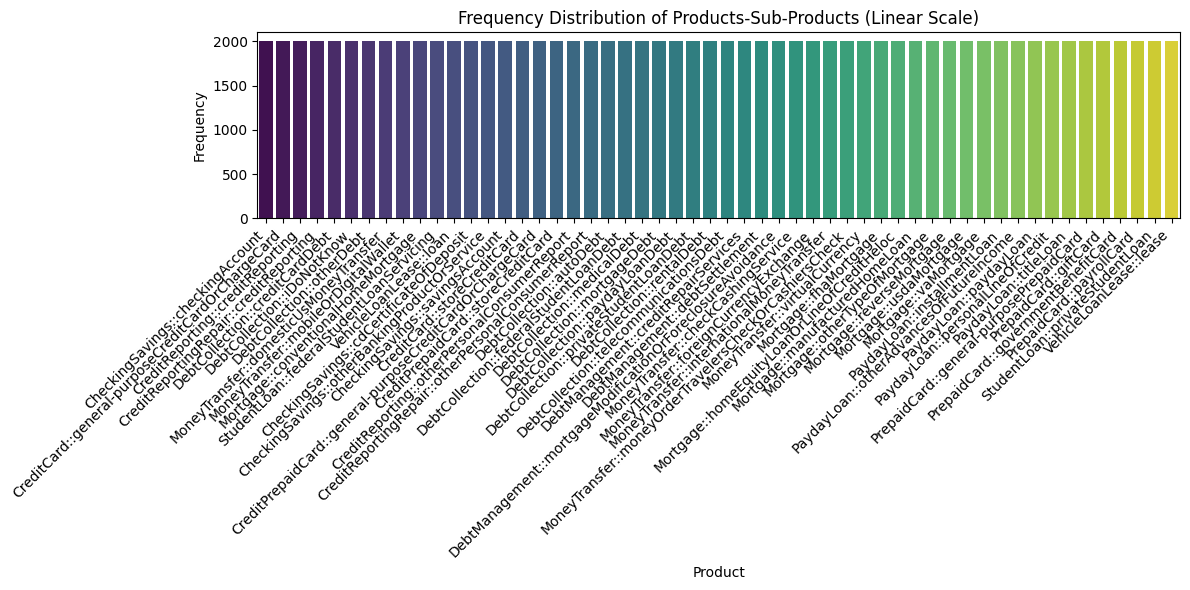

Bar chart showing the frequency distribution of Products-Sub-Products generated.


In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate frequency of each product
prosubpro_counts = df_balanced['hierarchical_label'].value_counts()

# Create the bar chart
plt.figure(figsize=(12, 6))
sns.barplot(x=prosubpro_counts.index, y=prosubpro_counts.values, palette='viridis')
plt.xlabel('Product')
plt.ylabel('Frequency')
plt.title('Frequency Distribution of Products-Sub-Products (Linear Scale)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()
print("Bar chart showing the frequency distribution of Products-Sub-Products generated.")

### Evaluation Metrics: Hierarchical Precision, Hierarchical Recall, Hierarchical F1-score

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np

# Function to split hierarchical labels into product and sub-product
def split_hierarchical_label(label):
    if '::' in label:
        return label.split('::')
    else:
        return [label, 'None'] # Handle cases with no sub-product

# Function to calculate hierarchical metrics
def hierarchical_metrics(y_true, y_pred):
    product_true = [split_hierarchical_label(label)[0] for label in y_true]
    sub_product_true = [split_hierarchical_label(label)[1] for label in y_true]
    product_pred = [split_hierarchical_label(label)[0] for label in y_pred]
    sub_product_pred = [split_hierarchical_label(label)[1] for label in y_pred]

    # Calculate metrics at the product level
    product_precision = precision_score(product_true, product_pred, average='weighted', zero_division=0)
    product_recall = recall_score(product_true, product_pred, average='weighted', zero_division=0)
    product_f1 = f1_score(product_true, product_pred, average='weighted', zero_division=0)

    # Calculate metrics at the sub-product level (only for non-None sub-products)
    # We need to filter for cases where both true and predicted sub-products are not 'None'
    valid_sub_product_true = [sub for i, sub in enumerate(sub_product_true) if sub != 'None' and sub_product_pred[i] != 'None']
    valid_sub_product_pred = [sub for i, sub in enumerate(sub_product_pred) if sub != 'None' and sub_product_true[i] != 'None']


    sub_product_precision = precision_score(valid_sub_product_true, valid_sub_product_pred, average='weighted', zero_division=0) if valid_sub_product_true else 0
    sub_product_recall = recall_score(valid_sub_product_true, valid_sub_product_pred, average='weighted', zero_division=0) if valid_sub_product_true else 0
    sub_product_f1 = f1_score(valid_sub_product_true, valid_sub_product_pred, average='weighted', zero_division=0) if valid_sub_product_true else 0


    # A simple way to combine scores (can be weighted based on importance)
    # Here, we'll just average them
    hierarchical_precision = (product_precision + sub_product_precision) / 2
    hierarchical_recall = (product_recall + sub_product_recall) / 2
    hierarchical_f1 = (product_f1 + sub_product_f1) / 2

    return {
        'product_precision': product_precision,
        'product_recall': product_recall,
        'product_f1': product_f1,
        'sub_product_precision': sub_product_precision,
        'sub_product_recall': sub_product_recall,
        'sub_product_f1': sub_product_f1,
        'hierarchical_precision': hierarchical_precision,
        'hierarchical_recall': hierarchical_recall,
        'hierarchical_f1': hierarchical_f1
    }


### Tokenize

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
import numpy as np

# Step 2 & 3: Tokenize and convert text to sequences
tokenizer = Tokenizer()
tokenizer.fit_on_texts(final_balanced_df['consumer_complaint_narrative'])
sequences = tokenizer.texts_to_sequences(final_balanced_df['consumer_complaint_narrative'])

# Step 4: Determine maximum sequence length (e.g., based on mean + 2 * std or a percentile)
# For simplicity, let's use a fixed value or calculate a percentile
sequence_lengths = [len(seq) for seq in sequences]
max_sequence_length = int(np.percentile(sequence_lengths, 95)) # Using 95th percentile

# Step 5: Pad sequences
padded_sequences = pad_sequences(sequences, maxlen=max_sequence_length, padding='post', truncating='post')

# Step 6 & 7: Encode hierarchical labels
label_encoder = LabelEncoder()
integer_encoded_labels = label_encoder.fit_transform(final_balanced_df['hierarchical_label'])

# Step 8: One-hot encode labels
one_hot_labels = to_categorical(integer_encoded_labels)

# Step 9: Split data into training and testing sets
X_train_padded, X_test_padded, y_train_one_hot, y_test_one_hot = train_test_split(
    padded_sequences, one_hot_labels, test_size=0.2, random_state=42, stratify=one_hot_labels)

print("Padded sequences shape:", padded_sequences.shape)
print("One-hot encoded labels shape:", one_hot_labels.shape)
print("X_train_padded shape:", X_train_padded.shape)
print("X_test_padded shape:", X_test_padded.shape)
print("y_train_one_hot shape:", y_train_one_hot.shape)
print("y_test_one_hot shape:", y_test_one_hot.shape)

Padded sequences shape: (108000, 615)
One-hot encoded labels shape: (108000, 54)
X_train_padded shape: (86400, 615)
X_test_padded shape: (21600, 615)
y_train_one_hot shape: (86400, 54)
y_test_one_hot shape: (21600, 54)


### LSTM Model

In [ ]:
from tensorflow.keras.layers import Embedding, LSTM, Dense, Input
from tensorflow.keras.models import Model

# Define the input layer
input_layer = Input(shape=(max_sequence_length,))

# Add the Embedding layer
vocab_size = len(tokenizer.word_index) + 1
embedding_dim = 100 # Choose an appropriate embedding size
embedding_layer = Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_sequence_length)(input_layer)

# Add the LSTM layer
lstm_layer = LSTM(units=128)(embedding_layer) # Choose an appropriate number of units

# Add Dense layers for classification
# The number of units in the final dense layer should be equal to the number of unique hierarchical labels
num_hierarchical_labels = one_hot_labels.shape[1]
dense_layer = Dense(units=64, activation='relu')(lstm_layer)
output_layer = Dense(units=num_hierarchical_labels, activation='softmax')(dense_layer)

# Create the Keras Model
model_lstm = Model(inputs=input_layer, outputs=output_layer)

# Print the model summary
model_lstm.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 615)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 615, 100)       │     4,139,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 128)            │       117,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 54)             │         3,510 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,268,814 (16.28 MB)

 Trainable params: 4,268,814 (16.28 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Compile the model
model_lstm.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
# Train the model
history_lstm = model_lstm.fit(X_train_padded, y_train_one_hot,
                    epochs=15, # Using 15 epochs
                    batch_size=64, # Using batch size of 64
                    validation_data=(X_test_padded, y_test_one_hot)) # Using test set for validation

Epoch 1/15
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 54s 35ms/step - accuracy: 0.0226 - loss: 3.9824 - val_accuracy: 0.0378 - val_loss: 3.9066
Epoch 2/15
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 48s 36ms/step - accuracy: 0.0386 - loss: 3.8986 - val_accuracy: 0.0474 - val_loss: 3.8671
Epoch 3/15
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 47s 35ms/step - accuracy: 0.0487 - loss: 3.8564 - val_accuracy: 0.0509 - val_loss: 3.8537
Epoch 4/15
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 47s 34ms/step - accuracy: 0.0557 - loss: 3.8160 - val_accuracy: 0.0799 - val_loss: 3.5708
Epoch 5/15
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 47s 35ms/step - accuracy: 0.0831 - loss: 3.4862 - val_accuracy: 0.0842 - val_loss: 3.3370
Epoch 6/15
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 49s 36ms/step - accuracy: 0.1095 - loss: 3.1419 - val_accuracy: 0.2102 - val_loss: 2.6132
Epoch 7/15
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 47s 35ms/step - accuracy: 0.2934 - loss: 2.2737 - val_accuracy: 0.4610 - val_loss: 1.8192
Epoch 8/15
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 47s 35ms/step - accuracy: 0.5287 -

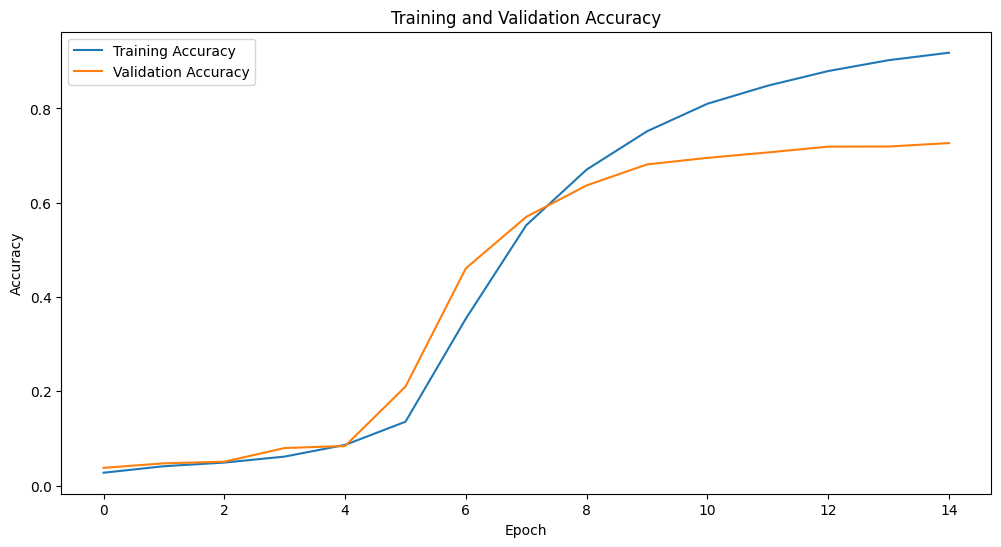

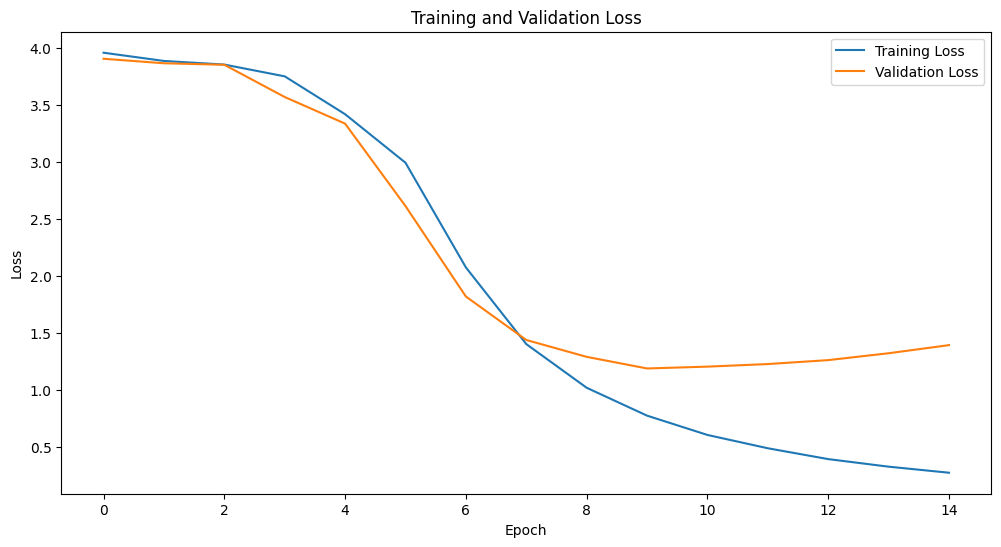

In [ ]:
import matplotlib.pyplot as plt

# Plot training and validation accuracy
plt.figure(figsize=(12, 6))
plt.plot(history_lstm.history['accuracy'], label='Training Accuracy')
plt.plot(history_lstm.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(history_lstm.history['loss'], label='Training Loss')
plt.plot(history_lstm.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# Make predictions on the test set
y_pred_one_hot = model_lstm.predict(X_test_padded)

# Convert one-hot encoded predictions back to class labels
y_pred_integer_encoded = np.argmax(y_pred_one_hot, axis=1)
y_pred_labels = label_encoder.inverse_transform(y_pred_integer_encoded)

# Convert one-hot encoded true labels back to class labels
y_test_integer_encoded = np.argmax(y_test_one_hot, axis=1)
y_test_labels = label_encoder.inverse_transform(y_test_integer_encoded)

# Calculate hierarchical metrics
metrics = hierarchical_metrics(y_test_labels, y_pred_labels)

# Display the calculated metrics
print("\nHierarchical Evaluation Metrics (LSTM Model):")
print(f"  Product Precision: {metrics['product_precision']:.4f}")
print(f"  Product Recall:    {metrics['product_recall']:.4f}")
print(f"  Product F1-score:  {metrics['product_f1']:.4f}")
print(f"  Sub-product Precision: {metrics['sub_product_precision']:.4f}")
print(f"  Sub-product Recall:    {metrics['sub_product_recall']:.4f}")
print(f"  Sub-product F1-score:  {metrics['sub_product_f1']:.4f}")
print(f"  Hierarchical Precision: {metrics['hierarchical_precision']:.4f}")
print(f"  Hierarchical Recall:    {metrics['hierarchical_recall']:.4f}")
print(f"  Hierarchical F1-score:  {metrics['hierarchical_f1']:.4f}")

675/675 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step

Hierarchical Evaluation Metrics (LSTM Model):
  Product Precision: 0.8510
  Product Recall:    0.8515
  Product F1-score:  0.8506
  Sub-product Precision: 0.7396
  Sub-product Recall:    0.7350
  Sub-product F1-score:  0.7343
  Hierarchical Precision: 0.7953
  Hierarchical Recall:    0.7933
  Hierarchical F1-score:  0.7925


### Bidirectional LSTM

In [ ]:
from tensorflow.keras.layers import Embedding, LSTM, Dense, Input, Bidirectional, Dropout
from tensorflow.keras.models import Model
import numpy as np  # in case it's not already imported

# Define the input layer
input_layer = Input(shape=(max_sequence_length,))

# Add the Embedding layer
vocab_size = len(tokenizer.word_index) + 1
embedding_dim = 100  # Choose an appropriate embedding size
embedding_layer = Embedding(
    input_dim=vocab_size,
    output_dim=embedding_dim,
    input_length=max_sequence_length,
    mask_zero=True  # helps LSTM ignore padded tokens
)(input_layer)

# Add the Bidirectional LSTM layer
# Note: units is per-direction. The concatenated output size becomes 2 * units.
bilstm_layer = Bidirectional(LSTM(units=128))(embedding_layer)

# (Optional) regularization
dense_prelayer = Dropout(0.3)(bilstm_layer)

# Add Dense layers for classification
num_hierarchical_labels = one_hot_labels.shape[1]
dense_layer = Dense(units=64, activation='relu')(dense_prelayer)
output_layer = Dense(units=num_hierarchical_labels, activation='softmax')(dense_layer)

# Create the Keras Model
model_bilstm = Model(inputs=input_layer, outputs=output_layer)

# Print the model summary
model_bilstm.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 615)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 615, 100)  │  4,139,800 │ input_layer_1[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, 615)       │          0 │ input_layer_1[0]… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 256)       │    234,496 │ embedding_1[0][0… │
│ (Bidirectional)     │                   │            │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 256)       │          0 │ bidirectional[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 64)        │     16,448 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 54)        │      3,510 │ dense_2[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 4,394,254 (16.76 MB)

 Trainable params: 4,394,254 (16.76 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Compile the model
model_bilstm.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


In [ ]:
# Train the model
history_bilstm = model_bilstm.fit(
    X_train_padded, y_train_one_hot,
    epochs=15,               # Using 15 epochs
    batch_size=64,           # Using batch size of 64
    validation_data=(X_test_padded, y_test_one_hot)  # Using test set for validation
)


Epoch 1/15
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 81s 58ms/step - accuracy: 0.0529 - loss: 3.7504 - val_accuracy: 0.1015 - val_loss: 3.2252
Epoch 2/15
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 81s 60ms/step - accuracy: 0.1039 - loss: 3.3072 - val_accuracy: 0.1870 - val_loss: 2.7563
Epoch 3/15
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 78s 58ms/step - accuracy: 0.2092 - loss: 2.6051 - val_accuracy: 0.3297 - val_loss: 2.1386
Epoch 4/15
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 79s 58ms/step - accuracy: 0.3600 - loss: 2.0183 - val_accuracy: 0.4695 - val_loss: 1.7086
Epoch 5/15
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 81s 60ms/step - accuracy: 0.5072 - loss: 1.5280 - val_accuracy: 0.5706 - val_loss: 1.3915
Epoch 6/15
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 78s 57ms/step - accuracy: 0.6186 - loss: 1.1708 - val_accuracy: 0.6376 - val_loss: 1.1963
Epoch 7/15
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 79s 58ms/step - accuracy: 0.7093 - loss: 0.9044 - val_accuracy: 0.6768 - val_loss: 1.0965
Epoch 8/15
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 79s 58ms/step - accuracy: 0.7717 -

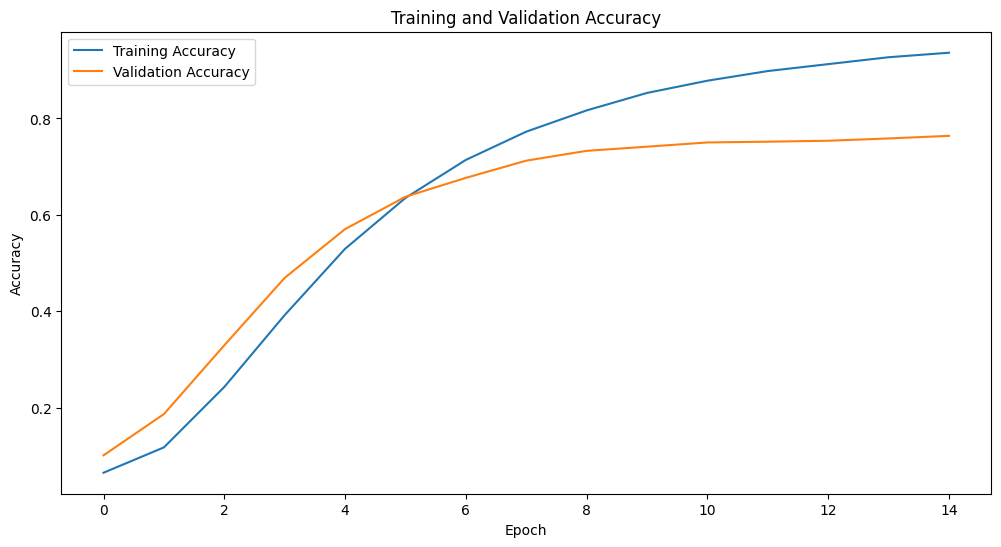

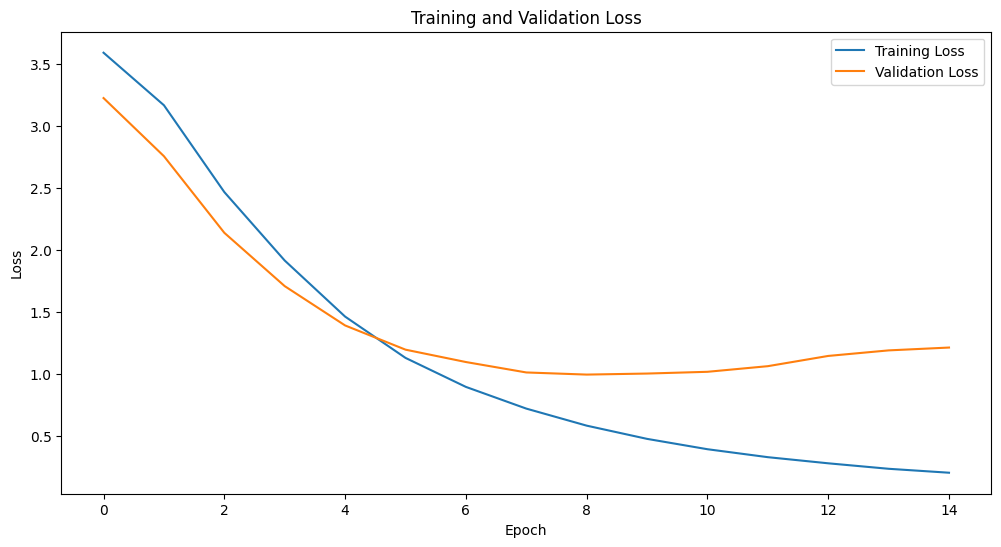

In [ ]:
import matplotlib.pyplot as plt

# Plot training and validation accuracy
plt.figure(figsize=(12, 6))
plt.plot(history_bilstm.history['accuracy'], label='Training Accuracy')
plt.plot(history_bilstm.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(history_bilstm.history['loss'], label='Training Loss')
plt.plot(history_bilstm.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# Make predictions on the test set
y_pred_one_hot = model_bilstm.predict(X_test_padded)

# Convert one-hot encoded predictions back to class labels
y_pred_integer_encoded = np.argmax(y_pred_one_hot, axis=1)
y_pred_labels = label_encoder.inverse_transform(y_pred_integer_encoded)

# Convert one-hot encoded true labels back to class labels
y_test_integer_encoded = np.argmax(y_test_one_hot, axis=1)
y_test_labels = label_encoder.inverse_transform(y_test_integer_encoded)

# Calculate hierarchical metrics
metrics = hierarchical_metrics(y_test_labels, y_pred_labels)

# Display the calculated metrics
print("\nHierarchical Evaluation Metrics (BiLSTM Model):")
print(f"  Product Precision: {metrics['product_precision']:.4f}")
print(f"  Product Recall:    {metrics['product_recall']:.4f}")
print(f"  Product F1-score:  {metrics['product_f1']:.4f}")
print(f"  Sub-product Precision: {metrics['sub_product_precision']:.4f}")
print(f"  Sub-product Recall:    {metrics['sub_product_recall']:.4f}")
print(f"  Sub-product F1-score:  {metrics['sub_product_f1']:.4f}")
print(f"  Hierarchical Precision: {metrics['hierarchical_precision']:.4f}")
print(f"  Hierarchical Recall:    {metrics['hierarchical_recall']:.4f}")
print(f"  Hierarchical F1-score:  {metrics['hierarchical_f1']:.4f}")

675/675 ━━━━━━━━━━━━━━━━━━━━ 12s 17ms/step

Hierarchical Evaluation Metrics (BiLSTM Model):
  Product Precision: 0.8668
  Product Recall:    0.8672
  Product F1-score:  0.8665
  Sub-product Precision: 0.7734
  Sub-product Recall:    0.7734
  Sub-product F1-score:  0.7715
  Hierarchical Precision: 0.8201
  Hierarchical Recall:    0.8203
  Hierarchical F1-score:  0.8190


### CNN-1D

In [ ]:
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping

# --- Define Hyperparameters for Regularization ---
DROPOUT_RATE = 0.4
L2_REGULARIZER = 0.001

# --- Define the Model Architecture ---
input_layer_cnn = Input(shape=(max_sequence_length,))

vocab_size = len(tokenizer.word_index) + 1
embedding_dim = 100 # Choose an appropriate embedding size


embedding_layer_cnn = Embedding(input_dim=vocab_size,
                                output_dim=embedding_dim,
                                input_length=max_sequence_length)(input_layer_cnn)

# 1. ADD L2 REGULARIZATION AND REDUCE FILTERS
conv1d_layer = Conv1D(filters=64, # Reduced from 128
                      kernel_size=5,
                      activation='relu',
                      kernel_regularizer=l2(L2_REGULARIZER))(embedding_layer_cnn) # Added L2

# 1. ADD DROPOUT AFTER CONV LAYER
conv1d_dropout = Dropout(DROPOUT_RATE)(conv1d_layer)

pooling_layer = GlobalMaxPooling1D()(conv1d_dropout)

num_hierarchical_labels = one_hot_labels.shape[1]

# 2. ADD L2 REGULARIZATION AND REDUCE UNITS
dense_layer_cnn = Dense(units=32, # Reduced from 64
                        activation='relu',
                        kernel_regularizer=l2(L2_REGULARIZER))(pooling_layer) # Added L2

# 2. ADD DROPOUT AFTER DENSE LAYER
dense_dropout = Dropout(DROPOUT_RATE)(dense_layer_cnn)

output_layer_cnn = Dense(units=num_hierarchical_labels, activation='softmax')(dense_dropout)

model_cnn_regularized = Model(inputs=input_layer_cnn, outputs=output_layer_cnn)

model_cnn_regularized.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

model_cnn_regularized.summary()


# --- Implement Early Stopping ---
# Monitors 'val_loss' (validation loss)
# patience=5 means it will wait 5 epochs after val_loss stops improving before stopping
# restore_best_weights=True ensures you get the model from the best epoch
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


# --- Train the Regularized Model ---
history_cnn_regularized = model_cnn_regularized.fit(
    X_train_padded, y_train_one_hot,
    epochs=50, # Increase epochs, as EarlyStopping will determine the actual stop point
    batch_size=64,
    validation_data=(X_test_padded, y_test_one_hot),
    callbacks=[early_stopping] # Pass the EarlyStopping callback
)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 615)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 615, 100)       │     4,134,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 611, 64)        │        32,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 611, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (None, 64)             │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 54)             │         1,782 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,170,126 (15.91 MB)

 Trainable params: 4,170,126 (15.91 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 17s 9ms/step - accuracy: 0.1092 - loss: 3.5277 - val_accuracy: 0.4467 - val_loss: 2.3140
Epoch 2/50
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.3793 - loss: 2.2264 - val_accuracy: 0.5562 - val_loss: 1.9202
Epoch 3/50
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.4792 - loss: 1.8921 - val_accuracy: 0.6019 - val_loss: 1.7287
Epoch 4/50
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.5338 - loss: 1.7012 - val_accuracy: 0.6306 - val_loss: 1.6037
Epoch 5/50
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.5695 - loss: 1.5796 - val_accuracy: 0.6506 - val_loss: 1.5202
Epoch 6/50
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.6056 - loss: 1.4600 - val_accuracy: 0.6680 - val_loss: 1.4370
Epoch 7/50
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.6245 - loss: 1.3929 - val_accuracy: 0.6804 - val_loss: 1.3880
Epoch 8/50
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 21s 8ms/step - accuracy: 0.6425 - loss: 1

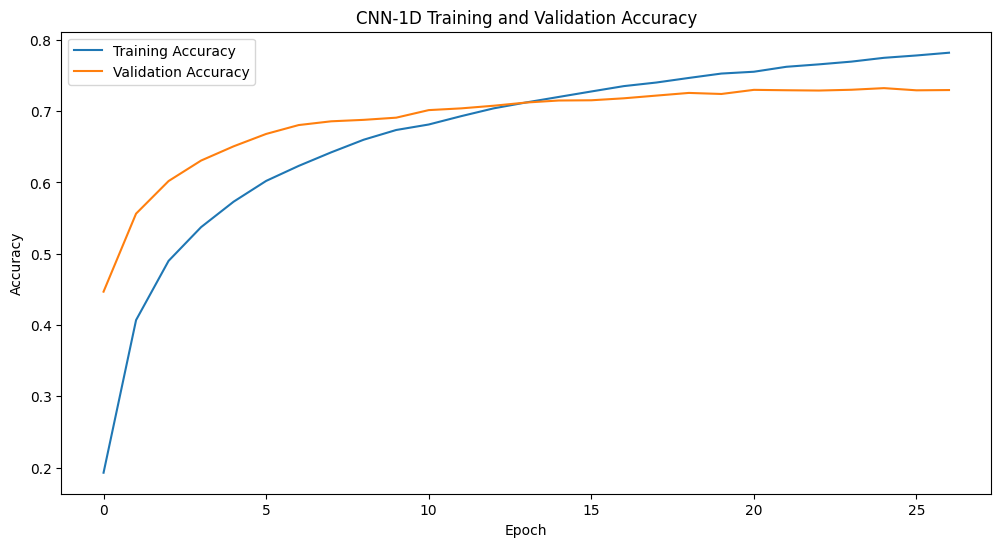

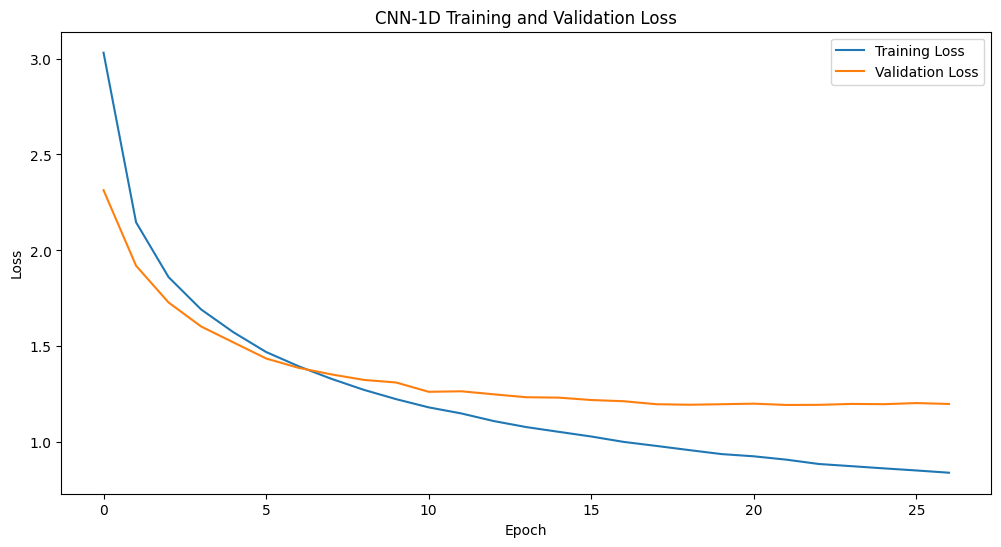

In [ ]:
import matplotlib.pyplot as plt

# Plot training and validation accuracy for CNN-1D
plt.figure(figsize=(12, 6))
plt.plot(history_cnn_regularized.history['accuracy'], label='Training Accuracy')
plt.plot(history_cnn_regularized.history['val_accuracy'], label='Validation Accuracy')
plt.title('CNN-1D Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss for CNN-1D
plt.figure(figsize=(12, 6))
plt.plot(history_cnn_regularized.history['loss'], label='Training Loss')
plt.plot(history_cnn_regularized.history['val_loss'], label='Validation Loss')
plt.title('CNN-1D Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# Make predictions on the test set using CNN-1D model
y_pred_one_hot_cnn = model_cnn_regularized.predict(X_test_padded)

# Convert one-hot encoded predictions back to class labels
y_pred_integer_encoded_cnn = np.argmax(y_pred_one_hot_cnn, axis=1)
y_pred_labels_cnn = label_encoder.inverse_transform(y_pred_integer_encoded_cnn)

# We already have y_test_labels from the previous evaluation
# Convert one-hot encoded true labels back to class labels
y_test_integer_encoded = np.argmax(y_test_one_hot, axis=1)
y_test_labels = label_encoder.inverse_transform(y_test_integer_encoded)


# Calculate hierarchical metrics for CNN-1D
metrics_cnn = hierarchical_metrics(y_test_labels, y_pred_labels_cnn)

# Display the calculated metrics
print("\nHierarchical Evaluation Metrics (CNN-1D Model):")
print(f"  Product Precision: {metrics_cnn['product_precision']:.4f}")
print(f"  Product Recall:    {metrics_cnn['product_recall']:.4f}")
print(f"  Product F1-score:  {metrics_cnn['product_f1']:.4f}")
print(f"  Sub-product Precision: {metrics_cnn['sub_product_precision']:.4f}")
print(f"  Sub-product Recall:    {metrics_cnn['sub_product_recall']:.4f}")
print(f"  Sub-product F1-score:  {metrics_cnn['sub_product_f1']:.4f}")
print(f"  Hierarchical Precision: {metrics_cnn['hierarchical_precision']:.4f}")
print(f"  Hierarchical Recall:    {metrics_cnn['hierarchical_recall']:.4f}")
print(f"  Hierarchical F1-score:  {metrics_cnn['hierarchical_f1']:.4f}")

675/675 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step

Hierarchical Evaluation Metrics (CNN-1D Model):
  Product Precision: 0.8505
  Product Recall:    0.8497
  Product F1-score:  0.8498
  Sub-product Precision: 0.7527
  Sub-product Recall:    0.7422
  Sub-product F1-score:  0.7446
  Hierarchical Precision: 0.8016
  Hierarchical Recall:    0.7960
  Hierarchical F1-score:  0.7972
